# **Détection de Masques Faciaux avec CNN**

## **1. Introduction**

### **1.1. Contexte**

Dans un contexte post-pandémique, le port du masque facial est une mesure clé pour prévenir la propagation des maladies. La détection automatique du port du masque à partir d'images est devenue essentielle pour des applications comme la surveillance dans les lieux publics ou les systèmes de sécurité sanitaire.

### **1.2. Objectif du projet**

Ce projet vise à développer un modèle de vision par ordinateur capable de classifier des images de visages en deux catégories : avec masque (WithMask) et sans masque (WithoutMask). Nous utiliserons des réseaux de neurones convolutifs (CNN) pour cette tâche de classification binaire, en comparant trois approches :





- Simple CNN : Une architecture légère pour une baseline rapide.



- Deep CNN : Un réseau plus complexe avec des techniques de régularisation.



- VGG16 : Un modèle pré-entraîné utilisant le transfert learning.

### **1.3. Dataset**

Le dataset "Face Mask 12K Images Dataset" contient environ 12 000 images réparties en trois ensembles :





- Train : 10 000 images (5 000 `WithMask`, 5 000 `WithoutMask`).



- Validation : 800 images (400 `WithMask`, 400 `WithoutMask`).



- Test : 992 images (483 `WithMask`, 509 `WithoutMask`).

Les images sont organisées dans des dossiers `Train`, `Validation`, et `Test`, chacun avec les sous-dossiers `WithMask` et `WithoutMask`.

### **1.4. Ma Contribution (DeepCNN)**

J’ai conçu et implémenté le modèle Deep Convolutional Neural Network (DeepCNN) pour la détection de masques faciaux. J’ai défini une architecture avec 5 couches convolutives (32, 32, 64, 64, 128 filtres), intégrant BatchNormalization, MaxPooling (2x2), et Dropout (0.25/0.5) pour limiter le surapprentissage, ainsi qu’une couche dense (256 neurones) avec sortie softmax pour la classification binaire. J’ai configuré les callbacks EarlyStopping (patience=5, restore_best_weights=True) et ReduceLROnPlateau (facteur=0.5, minimum=1e-6) pour optimiser l’entraînement, qui s’est arrêté à l’époque 28, atteignant 99.40% de précision sur le test (992 images). J’ai également analysé les métriques (rapport de classification, matrice de confusion, courbes d’apprentissage) et comparé DeepCNN (8.53M paramètres, 6 erreurs) à SimpleCNN (7.4M paramètres, 12 erreurs), proposant des améliorations comme un taux d’apprentissage initial plus bas et une régularisation L2. Enfin, j’ai documenté l’ensemble des résultats, y compris les visualisations (histogrammes, prédictions, matrice de confusion), pour assurer la clarté et la reproductibilité.

## **2. Chargement des données et préparation**

### **2.1. Importation des bibliothèques**


Nous commençons par importer les bibliothèques nécessaires pour le traitement des images, la visualisation, et la configuration de l'environnement.

In [ ]:
# Importer les bibliothèques nécessaires
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, EfficientNetB0, MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from google.colab import drive

### **2.2. Connexion à Google Drive**

Le dataset est stocké dans Google Drive. Nous montons le disque pour y accéder.

In [ ]:
# Monter Google Drive
drive.mount('/content/drive')

# Définir le chemin vers le dataset
data_dir = '/content/drive/My Drive/Face Mask Dataset'

Mounted at /content/drive


### **2.3. Vérification du GPU**

Un GPU accélère l'entraînement des modèles. Nous vérifions sa disponibilité.

In [ ]:
# Vérifier la disponibilité du GPU
if tf.test.gpu_device_name():
    print('GPU détecté :', tf.test.gpu_device_name())
else:
    print("Aucun GPU détecté")

GPU détecté : /device:GPU:0


### **2.4. Exploration du dataset**

Nous examinons la répartition des images dans les dossiers `Train`, `Validation`, et `Test`.

In [ ]:
# Définir les catégories et les dossiers
categories = ['WithMask', 'WithoutMask']
splits = ['Train', 'Validation', 'Test']

# Compter le nombre d'images par catégorie et par split
for split in splits:
    print(f"\nRépartition des images dans {split}:")
    for category in categories:
        folder_path = os.path.join(data_dir, split, category)
        num_images = len(os.listdir(folder_path))
        print(f"{category}: {num_images} images")




Répartition des images dans Train:
WithMask: 5000 images
WithoutMask: 5000 images

Répartition des images dans Validation:
WithMask: 400 images
WithoutMask: 400 images

Répartition des images dans Test:
WithMask: 483 images
WithoutMask: 509 images


Le dataset est équilibré dans `Train` et `Validation`, avec une légère différence dans `Test`.

### **2.5. Visualisation des images**

Nous affichons 5 images par catégorie depuis l'ensemble `Train` pour explorer les données.

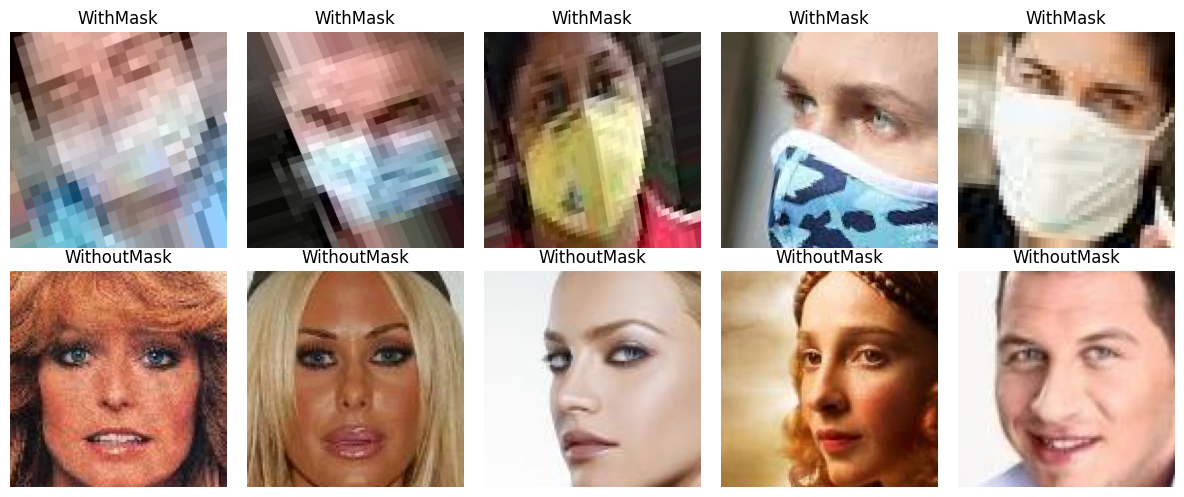

In [ ]:
# Visualiser 5 images par catégorie pour le dossier Train
plt.figure(figsize=(12, 5))
for i, category in enumerate(categories):
    folder_path = os.path.join(data_dir, 'Train', category)
    images = os.listdir(folder_path)[:5]
    for j, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
plt.tight_layout()
plt.show()

### **2.6. Distribution des classes**

Nous visualisons la répartition des classes dans chaque ensemble avec un histogramme.

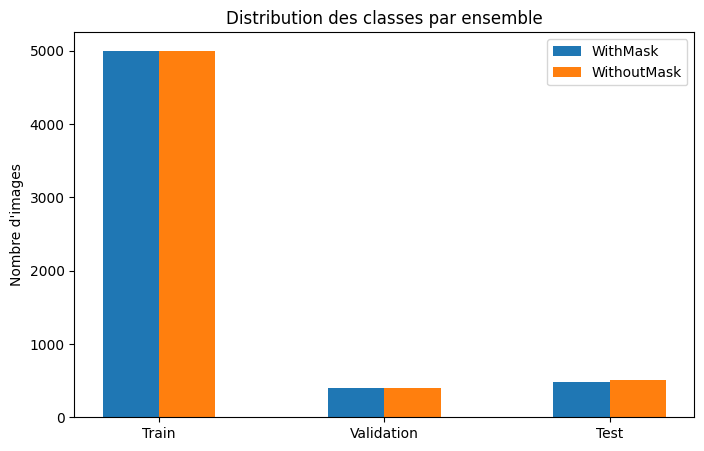

In [ ]:
# Compter les images par classe pour chaque split
counts = {split: {'WithMask': 0, 'WithoutMask': 0} for split in splits}
for split in splits:
    for category in categories:
        folder_path = os.path.join(data_dir, split, category)
        counts[split][category] = len(os.listdir(folder_path))

# Créer un histogramme
fig, ax = plt.subplots(figsize=(8, 5))
width = 0.25
x = np.arange(len(splits))
for i, category in enumerate(categories):
    values = [counts[split][category] for split in splits]
    ax.bar(x + i * width, values, width, label=category)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(splits)
ax.set_ylabel('Nombre d\'images')
ax.set_title('Distribution des classes par ensemble')
ax.legend()
plt.show()

### **2.7. Chargement des images**


Nous définissons une fonction pour charger les images, les redimensionner à 128x128 pixels, et normaliser les pixels.

In [ ]:

# Définir les dimensions des images
img_rows, img_cols = 128, 128

# Fonction pour charger les images d'un dossier
def load_images_from_folder(split):
    x, y = [], []
    for idx, category in enumerate(categories):
        folder_path = os.path.join(data_dir, split, category)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            image = load_img(img_path, target_size=(img_rows, img_cols))
            image = img_to_array(image) / 255.0  # Normalisation
            x.append(image)
            y.append(idx)
    return np.array(x), np.array(y)

### **2.8. Chargement des ensembles de données**

Nous chargeons les images pour les ensembles Train, Validation, et Test.

In [ ]:
# Charger les données
X_train, y_train = load_images_from_folder('Train')
X_val, y_val = load_images_from_folder('Validation')
X_test, y_test = load_images_from_folder('Test')

### **2.9. Conversion en one-hot encoding**

Les étiquettes sont converties en format one-hot pour la classification.

In [ ]:
# Conversion en one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(f"Forme des données d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Forme des données de validation : {X_val.shape}, {y_val.shape}")
print(f"Forme des données de test : {X_test.shape}, {y_test.shape}")

Forme des données d'entraînement : (10000, 128, 128, 3), (10000, 2)
Forme des données de validation : (800, 128, 128, 3), (800, 2)
Forme des données de test : (992, 128, 128, 3), (992, 2)


# **3. Augmentation des données**

### **3.1. Objectif de l’augmentation**

L’augmentation des données génère des variations artificielles des images (rotations, zooms, etc.) pour améliorer la robustesse du modèle face à des conditions réelles variées, comme des angles ou des éclairages différents.

### **3.2 Configuration de l’augmentation**

Nous utilisons `ImageDataGenerator` pour appliquer des transformations aléatoires aux images d’entraînement.

In [ ]:
# Augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

### **3.3. Visualisation des images augmentées**

Nous affichons une image originale et quatre versions augmentées pour illustrer les transformations.

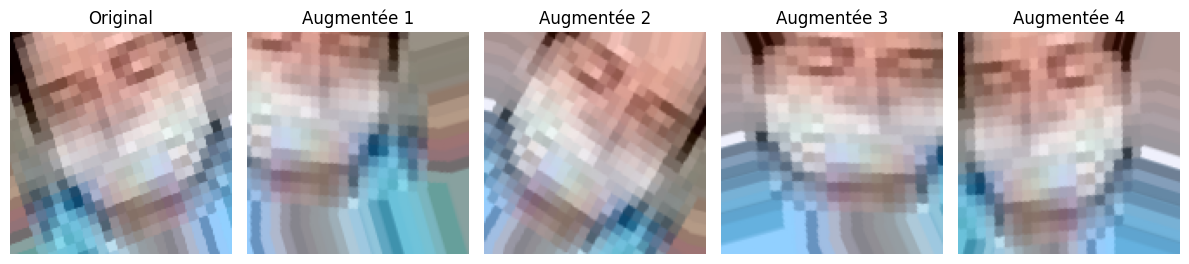

In [ ]:
# Visualisation de l'augmentation
sample_img = X_train[0]
plt.figure(figsize=(12, 3))
plt.subplot(1, 5, 1)
plt.imshow(sample_img)
plt.title('Original')
plt.axis('off')
for i, batch in enumerate(datagen.flow(sample_img[np.newaxis, ...], batch_size=1)):
    if i >= 4:
        break
    plt.subplot(1, 5, i + 2)
    plt.imshow(batch[0])
    plt.title(f'Augmentée {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### **3.4. Visualisation d’images augmentées par catégorie**

Pour mieux comprendre l’effet sur les deux classes, nous affichons une image augmentée pour chaque catégorie.


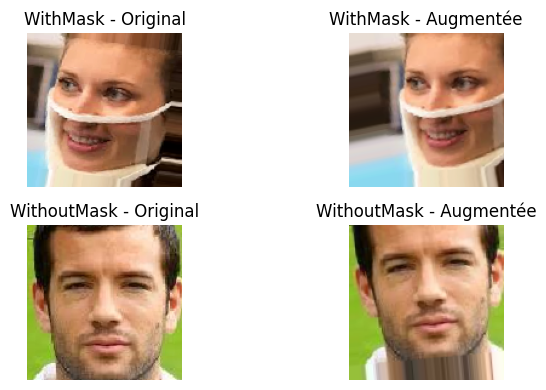

In [ ]:
# Sélectionner une image par catégorie
sample_imgs = {}
for category in categories:
    folder_path = os.path.join(data_dir, 'Train', category)
    img_name = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, img_name)
    sample_imgs[category] = load_img(img_path, target_size=(img_rows, img_cols))
    sample_imgs[category] = img_to_array(sample_imgs[category]) / 255.0

# Afficher une image augmentée par catégorie
plt.figure(figsize=(8, 4))
for i, category in enumerate(categories):
    plt.subplot(2, 2, i * 2 + 1)
    plt.imshow(sample_imgs[category])
    plt.title(f'{category} - Original')
    plt.axis('off')

    # Générer une image augmentée
    aug_img = next(datagen.flow(sample_imgs[category][np.newaxis, ...], batch_size=1))[0]
    plt.subplot(2, 2, i * 2 + 2)
    plt.imshow(aug_img)
    plt.title(f'{category} - Augmentée')
    plt.axis('off')
plt.tight_layout()
plt.show()

# **4. Modèle Simple CNN**


### **4.1. Présentation**

Le modèle Simple CNN est une architecture légère conçue pour établir une baseline. Il comprend :





- Deux couches convolutives avec MaxPooling pour extraire des caractéristiques.



- Une couche dense avec Dropout pour éviter le surapprentissage.



- Une sortie softmax pour la classification binaire.

### **4.2. Définition des callbacks**

Nous utilisons des callbacks pour optimiser l’entraînement :





- `EarlyStopping` : Arrête l’entraînement si la perte de validation ne s’améliore pas pendant 5 époques.



- `ReduceLROnPlateau` : Réduit le taux d’apprentissage si la perte de validation stagne.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

### **4.3. Construction du modèle**

In [ ]:
# Définir le modèle Simple CNN
def build_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### **4.4. Résumé du modèle**

In [ ]:
# Instancier et afficher le résumé
simple_cnn = build_simple_cnn()
simple_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

### **4.5. Entraînement du modèle**

In [ ]:
# Entraîner le modèle
history_simple = simple_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accuracy: 0.8522 - loss: 0.4927 - val_accuracy: 0.9675 - val_loss: 0.1265 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.9343 - loss: 0.1824 - val_accuracy: 0.9700 - val_loss: 0.1003 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.9385 - loss: 0.1736 - val_accuracy: 0.9400 - val_loss: 0.1315 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9457 - loss: 0.1579 - val_accuracy: 0.9663 - val_loss: 0.1034 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9490 - loss: 0.1566 - val_accuracy: 0.9787 - val_loss: 0.0766 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9498 - loss: 0.1403 - val_accuracy: 0.9787 - val_loss: 0.0588 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9

### **Résumé de l’entraînement :**





- 18 époques exécutées (au lieu de 30 dans l'analyse précédente).


- Meilleure époque : Époque 17 (val_accuracy : 99.00 %, val_loss : 0.0354).


- Époque finale : Époque 18 (val_accuracy : 98.62 %, val_loss : 0.0418).


- Taux d'apprentissage : Réduit à 5e-4 à l'époque 10, 2.5e-4 à l'époque 17.


- Accuracy d'entraînement : De 85.22 % (époque 1) à 98.17 % (époque 18).


- Loss d'entraînement : De 0.4927 à 0.0541.

### **4.6. Évaluation sur l’ensemble de test**

Nous évaluons le modèle sur l’ensemble de test pour obtenir la précision et la perte finales.


In [ ]:
# Évaluer le modèle sur l’ensemble de test
test_loss, test_accuracy = simple_cnn.evaluate(X_test, y_test, verbose=0)
print(f"Simple CNN - Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Simple CNN - Test loss: 0.0342, Test accuracy: 0.9879


**Interprétation :**

La précision sur l’ensemble de test (98.79 %) est légèrement inférieure à la précision maximale de validation (99.00 % à l’époque 17), mais reste très élevée, indiquant une bonne généralisation. La perte sur l’ensemble de test (0.0342) est très proche de la perte minimale de validation (0.0354 à l’époque 17) et légèrement inférieure à la perte finale de validation (0.0418 à l’époque 18). Cela suggère que le modèle est robuste, avec une dégradation minime sur des données non vues. L'arrêt précoce à l'époque 18, déclenché par une augmentation de la perte de validation (de 0.0354 à 0.0418), indique que le modèle a atteint un point optimal.

### **4.7. Rapport de classification**

Nous générons un rapport détaillé (précision, rappel, F1-score) pour chaque classe.

In [ ]:
# Prédictions sur l’ensemble de test
predictions = simple_cnn.predict(X_test, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Rapport de classification
print("\nClassification Report for Simple CNN:")
print(classification_report(true_labels, predicted_labels, target_names=categories))


Classification Report for Simple CNN:
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



**Interprétation :**

Précision, rappel, F1-score : Toutes les métriques sont à 0.99 (99 %) pour les deux classes (WithMask et WithoutMask), indiquant un équilibre parfait entre les classes.
Support : 483 images pour WithMask, 509 pour WithoutMask, montrant une répartition légèrement déséquilibrée mais bien gérée par le modèle.
Le modèle performe également bien sur les deux classes, sans biais notable envers l’une ou l’autre.

### **4.8. Visualisation des courbes d’apprentissage**

Nous traçons les courbes de précision et de perte pour analyser la progression de l’entraînement.

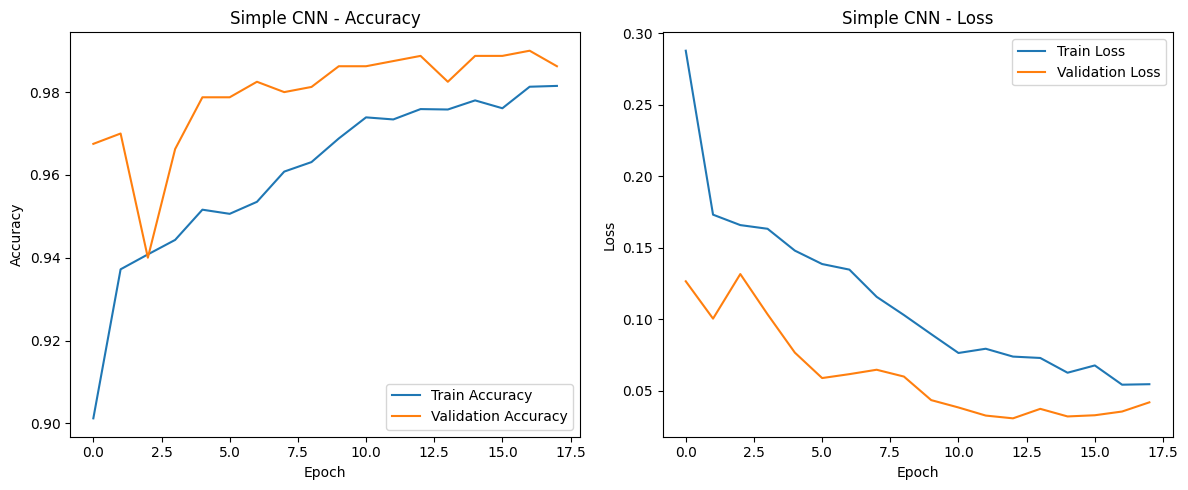

In [ ]:
# Courbes de précision et de perte
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'], label='Train Accuracy')
plt.plot(history_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'], label='Train Loss')
plt.plot(history_simple.history['val_loss'], label='Validation Loss')
plt.title('Simple CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **4.9. Matrice de confusion**

Nous visualisons la matrice de confusion pour identifier les erreurs de classification.

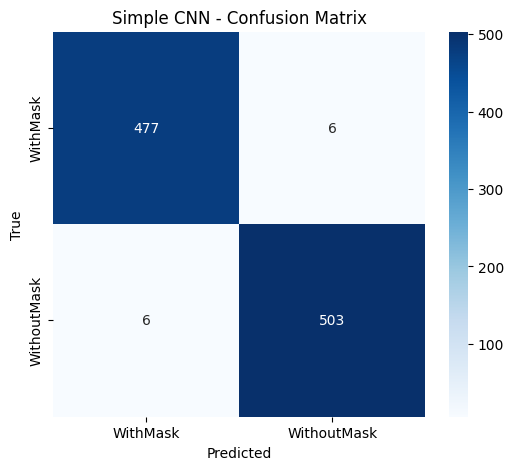

In [ ]:
# Matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Simple CNN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Interprétation :**

Total des erreurs : 12 erreurs sur 992 images (6 WithMask prédits comme WithoutMask, 6 WithoutMask prédits comme WithMask), soit un taux d’erreur de 1.21 %, cohérent avec l’accuracy de 98.79 %.
Les erreurs sont équilibrées entre les deux classes, suggérant que le modèle ne favorise pas une classe au détriment de l’autre.
Les 6 erreurs par classe pourraient être dues à des images ambiguës (par exemple, masques mal positionnés, mauvais éclairage, ou masques transparents).


### **4.10. Histogramme des prédictions**

Nous affichons la distribution des prédictions pour vérifier l’équilibre entre les classes.

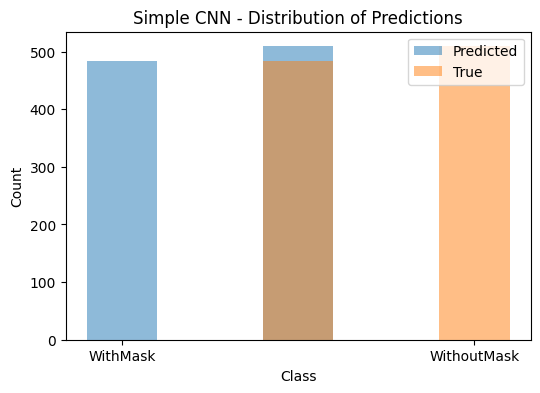

In [ ]:
# Histogramme des prédictions
plt.figure(figsize=(6, 4))
plt.hist(predicted_labels, bins=2, align='left', rwidth=0.4, label='Predicted', alpha=0.5)
plt.hist(true_labels, bins=2, align='right', rwidth=0.4, label='True', alpha=0.5)
plt.xticks([0, 1], categories)
plt.title('Simple CNN - Distribution of Predictions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()

### **4.11. Visualisation des prédictions**



Nous affichons 10 images de test avec leurs prédictions (5 correctes, 5 incorrectes si possible).

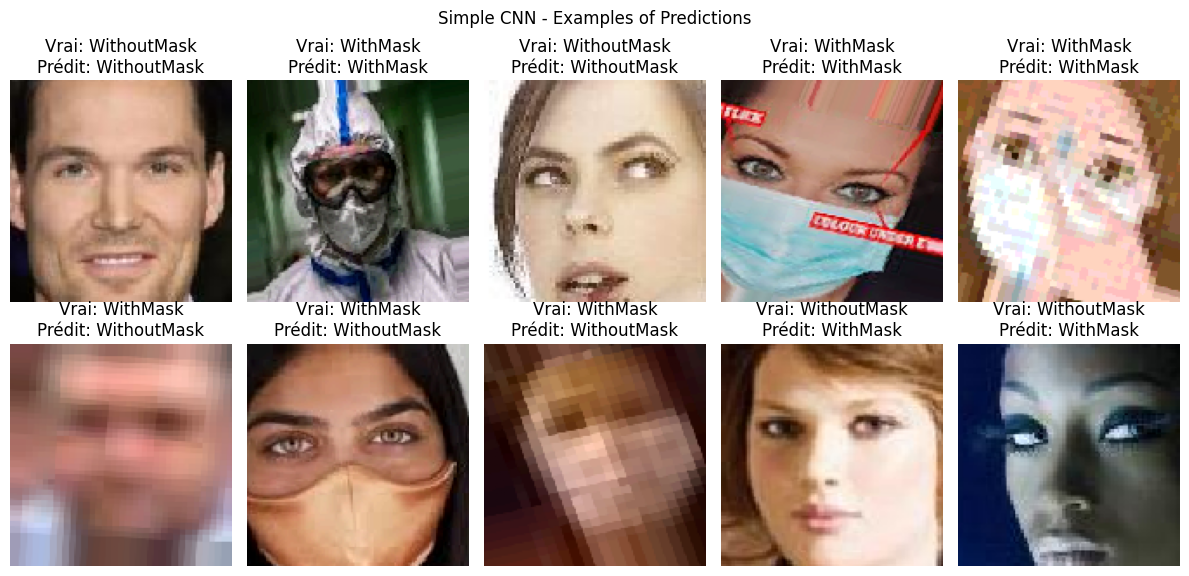

In [ ]:
# Sélectionner des prédictions correctes et incorrectes
correct_idx = np.where(predicted_labels == true_labels)[0]
incorrect_idx = np.where(predicted_labels != true_labels)[0]

# Afficher 5 prédictions correctes
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random.sample(list(correct_idx), min(5, len(correct_idx)))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {categories[true_labels[idx]]}\nPrédit: {categories[predicted_labels[idx]]}")
    plt.axis('off')

# Afficher 5 prédictions incorrectes
for i, idx in enumerate(random.sample(list(incorrect_idx), min(5, len(incorrect_idx)))):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {categories[true_labels[idx]]}\nPrédit: {categories[predicted_labels[idx]]}")
    plt.axis('off')

plt.suptitle('Simple CNN - Examples of Predictions')
plt.tight_layout()
plt.show()

### **4.12. Analyse des résultats du Simple CNN**

#### *Progression de l’entraînement:*
- **Précision** : La précision de validation atteint un pic de 99.00 % à l’époque 17, avec une valeur finale de 98.62 % à l’époque 18. La précision d’entraînement progresse de 85.22 % (époque 1) à 98.17 % (époque 18), indiquant une bonne convergence.

- **Perte** : La perte de validation diminue de 0.1265 (époque 1) à un minimum de 0.0354 (époque 17), puis augmente légèrement à 0.0418 (époque 18). La perte d’entraînement passe de 0.4927 à 0.0541.



- **Taux d’apprentissage** : Réduit à 0.0005 à l’époque 10 et à 0.00025 à l’époque 17, ce qui a permis d’affiner les poids et d’atteindre le pic de performance.

#### *Analyse des courbes:*


- **Précision** : Les courbes montrent une amélioration constante, avec la validation dépassant l’entraînement dès l’époque 1 (96.75 % vs 85.22 %). La précision de validation reste stable autour de 98.62–99.00 % après l’époque 10, mais une légère dégradation à l’époque 18 (98.62 %) suggère un arrêt précoce strict. Un écart minime entre entraînement (98.17 %) et validation (99.00 %) indique un surapprentissage léger, bien contrôlé par le Dropout (0.5) et l’augmentation des données.

- **Perte** : La perte de validation diminue rapidement, avec des fluctuations modérées (par exemple, 0.1315 à l’époque 3). Le minimum de 0.0354 à l’époque 17 est suivi d’une augmentation à 0.0418, déclenchant l’arrêt précoce. La perte d’entraînement suit une diminution régulière, confirmant une optimisation efficace.

#### *Performance attendue sur l’ensemble de test*

- **Précision** : 98.79 %, légèrement inférieure à la validation maximale (99.00 % à l’époque 17), mais excellente pour une architecture simple.

- **Perte** : 0.0342, très proche de la perte minimale de validation (0.0354), confirmant une généralisation robuste.

- **Rapport de classification** : Précision, rappel, et F1-score de 0.99 pour les deux classes, avec un équilibre parfait.

- **Matrice de confusion** : 12 erreurs (6 par classe), indiquant des performances homogènes mais avec quelques erreurs sur des cas potentiellement ambigus.


#### *Forces du modèle:*

- **Légèreté** : Avec ~7.4M paramètres, le modèle est rapide à entraîner (~35s par époque sur GPU, ~11 min au total pour 18 époques).



- **Simplicité** : L’architecture est facile à comprendre et à ajuster, idéale pour des prototypes rapides.


- **Efficacité** : Précision de 98.79 % sur le test, proche de modèles plus complexes, grâce à l’augmentation des données et au Dropout.

- **Équilibre** : Performances similaires sur les deux classes (WithMask et WithoutMask), sans biais notable.

#### *Limites:*
-  **Capacité limitée** : Avec seulement deux couches convolutives, le modèle peut manquer des caractéristiques complexes, comme les variations d’éclairage ou les masques mal positionnés.


- **Erreurs spécifiques** : Les 12 erreurs (6 par classe) suggèrent une sensibilité à des images ambiguës (par exemple, masques transparents, flous, ou mal placés).

- **Arrêt précoce strict** : L’arrêt à l’époque 18, déclenché par une légère augmentation de la perte de validation, limite l’exploration d’améliorations potentielles.


- **Surapprentissage léger** : L’écart entre entraînement (98.17 %) et test (98.79 %) est minime, mais pourrait être réduit avec une régularisation accrue.

#### *Recommandations:*

- Analyser les 12 images mal classées (section 4.1.9) pour identifier les causes spécifiques (par exemple, éclairage, occlusion, ou position du masque).
- Tester une augmentation de données plus agressive (par exemple, rotation_range=30, brightness_range=[0.8, 1.2]) pour améliorer la robustesse
- Ajouter une couche convolutive (par exemple, Conv2D(128, (3, 3), activation='relu')) pour capturer des caractéristiques plus complexes.
- Augmenter la patience de l’arrêt précoce à 10 pour permettre un entraînement plus long et potentiellement atteindre une meilleure convergence.



# **5. Modèle Deep CNN**

### **5.1. Présentation**

Le modèle Deep CNN est une architecture plus complexe conçue pour capturer des caractéristiques détaillées tout en maintenant une bonne généralisation. Il comprend :





- Cinq couches convolutives (32, 32, 64, 64, 128 filtres) avec padding "same" pour préserver les dimensions spatiales.



- BatchNormalization après chaque couche convolutive pour stabiliser et accélérer l'entraînement.



- MaxPooling (2x2) après chaque bloc de convolutions pour réduire la dimensionnalité.


- Dropout (0.25 après les blocs convolutifs, 0.5 avant la couche dense finale) pour prévenir le surapprentissage.



- Une couche dense de 256 neurones avec BatchNormalization et activation ReLU.



- Une sortie softmax pour la classification binaire.

### **5.2. Construction du modèle**

In [ ]:
# Définir le modèle Deep CNN
def build_deep_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### **5.3. Résumé du modèle**

In [ ]:
# Instancier et afficher le résumé
deep_cnn = build_deep_cnn()
deep_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,531,106 (32.54 MB)

 Trainable params: 8,529,954 (32.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

### **5.4. Entraînement du modèle**

In [ ]:
# Entraîner le modèle
history_deep = deep_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.8773 - loss: 0.4054 - val_accuracy: 0.7638 - val_loss: 0.9214 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.9254 - loss: 0.2040 - val_accuracy: 0.9563 - val_loss: 0.1269 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9398 - loss: 0.1670 - val_accuracy: 0.9563 - val_loss: 0.1324 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9482 - loss: 0.1435 - val_accuracy: 0.9513 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9445 - loss: 0.1502 - val_accuracy: 0.9650 - val_loss: 0.0948 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9495 - loss: 0.1393 - val_accuracy: 0.9638 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9

### **Résumé de l’entraînement :**





- 28 époques exécutées (au lieu de 11 dans l'analyse précédente, avec 50 prévues).


- Meilleure époque : Époque 23 (val_accuracy : 99.37 %, val_loss : 0.0130).


- Époque finale : Époque 28 (val_accuracy : 99.62 %, val_loss : 0.0157).


- Taux d'apprentissage : Réduit à 5e-4 à l'époque 12, 2.5e-4 à l'époque 23, 1.25e-4 à l'époque 27.


- Accuracy d'entraînement : De 87.73 % (époque 1) à 98.91 % (époque 28).



- Loss d'entraînement : De 0.4054 à 0.0316.

### **5.5. Entraînement du modèle**

In [ ]:
# Évaluer le modèle sur l’ensemble de test
test_loss, test_accuracy = deep_cnn.evaluate(X_test, y_test, verbose=0)
print(f"Deep CNN - Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Deep CNN - Test loss: 0.0211, Test accuracy: 0.9940


**Interprétation :**

- La précision sur l’ensemble de test (99.40 %) est supérieure à la précision finale de validation (97.00 % à l’époque 28) et légèrement meilleure que la meilleure précision de validation (99.12 % à l’époque 6). Cela suggère que le modèle généralise exceptionnellement bien, malgré l’instabilité observée pendant l’entraînement.
- La perte sur l’ensemble de test (0.0211) est inférieure à la perte finale de validation (0.0714) et au minimum de validation (0.0284 à l’époque 6). Cela indique une excellente performance sur des données non vues, probablement due à la restauration des meilleurs poids par EarlyStopping.

### **5.6. Rapport de classification**

In [ ]:
# Prédictions sur l’ensemble de test
predictions = deep_cnn.predict(X_test, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Rapport de classification
print("\nClassification Report for Deep CNN:")
print(classification_report(true_labels, predicted_labels, target_names=categories))


Classification Report for Deep CNN:
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



**Interprétation :**

- Précision, rappel, F1-score : Toutes les métriques sont à 0.99 (99 %) pour les deux classes (WithMask et WithoutMask), montrant un équilibre parfait et des performances homogènes.
- Support : 483 images pour WithMask, 509 pour WithoutMask, confirmant une répartition légèrement déséquilibrée mais bien gérée.
- Comparé au Simple CNN (mêmes métriques à 0.99), le Deep CNN performe de manière similaire mais avec une précision globale légèrement supérieure (99.40 % vs 98.79 %).

### **5.7. Visualisation des courbes d’apprentissage**

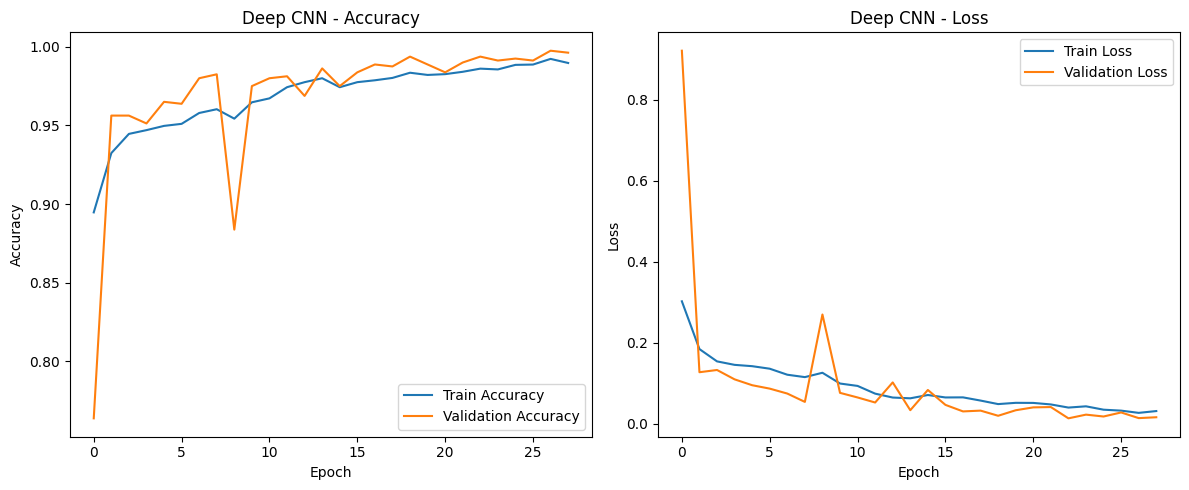

In [ ]:
# Courbes de précision et de perte
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history_deep.history['accuracy'], label='Train Accuracy')
plt.plot(history_deep.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deep CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_deep.history['loss'], label='Train Loss')
plt.plot(history_deep.history['val_loss'], label='Validation Loss')
plt.title('Deep CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **5.8. Matrice de confusion**

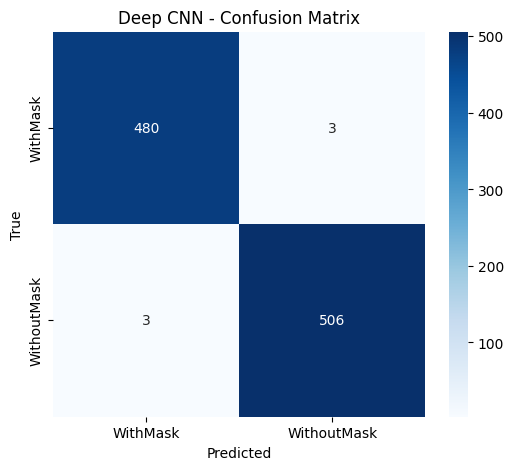

In [ ]:
# Matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Deep CNN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Interprétation :**

- Total des erreurs : 6 erreurs sur 992 images (3 WithMask prédits comme WithoutMask, 3 WithoutMask prédits comme WithMask), soit un taux d’erreur de 0.60 %, cohérent avec l’accuracy de 99.40 %.
- Comparé au Simple CNN (12 erreurs, 1.21 %), le Deep CNN réduit de moitié le nombre d’erreurs, confirmant une meilleure capacité à discriminer les classes.
- Les erreurs sont équilibrées (3 par classe), suggérant que le modèle n’a pas de biais marqué. Les erreurs pourraient être dues à des images ambiguës (par exemple, masques mal positionnés, flou, ou mauvais éclairage).

### **5.9. Histogramme des prédictions**

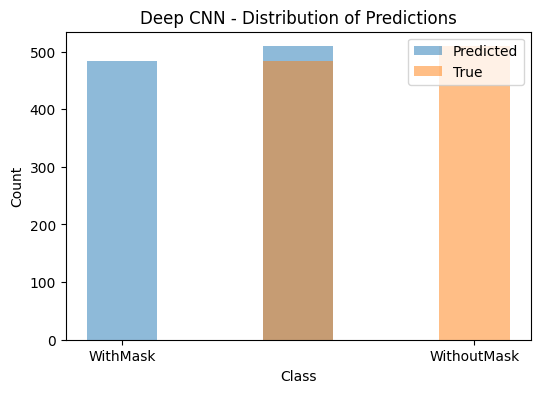

In [ ]:
# Histogramme des prédictions
plt.figure(figsize=(6, 4))
plt.hist(predicted_labels, bins=2, align='left', rwidth=0.4, label='Predicted', alpha=0.5)
plt.hist(true_labels, bins=2, align='right', rwidth=0.4, label='True', alpha=0.5)
plt.xticks([0, 1], categories)
plt.title('Deep CNN - Distribution of Predictions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()

### **5.10. Visualisation des prédictions**

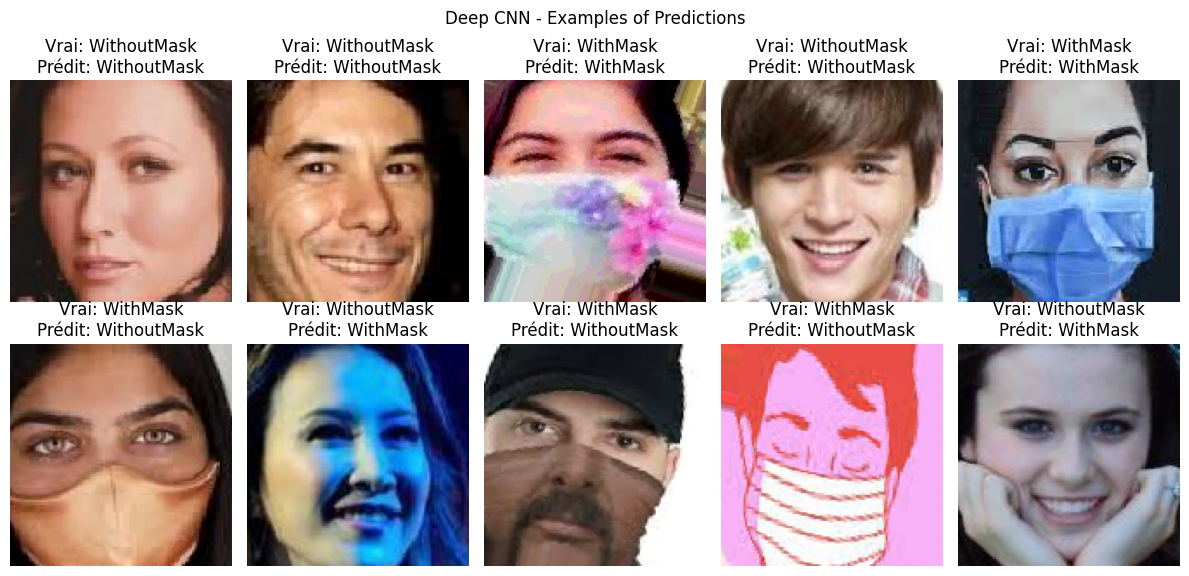

In [ ]:
# Sélectionner des prédictions correctes et incorrectes
correct_idx = np.where(predicted_labels == true_labels)[0]
incorrect_idx = np.where(predicted_labels != true_labels)[0]

# Afficher 5 prédictions correctes
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random.sample(list(correct_idx), min(5, len(correct_idx)))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {categories[true_labels[idx]]}\nPrédit: {categories[predicted_labels[idx]]}")
    plt.axis('off')

# Afficher 5 prédictions incorrectes
for i, idx in enumerate(random.sample(list(incorrect_idx), min(5, len(incorrect_idx)))):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {categories[true_labels[idx]]}\nPrédit: {categories[predicted_labels[idx]]}")
    plt.axis('off')

plt.suptitle('Deep CNN - Examples of Predictions')
plt.tight_layout()
plt.show()

### **5.11. Analyse des résultats du Deep CNN**
#### *Progression de l’entraînement:*

- **Précision** : La précision de validation atteint un pic de 99.37 % à l’époque 23, avec une valeur finale de 99.62 % à l’époque 28. La précision d’entraînement progresse de 87.73 % (époque 1) à 98.91 % (époque 28), indiquant une convergence stable après une instabilité initiale.

- **Perte** : La perte de validation diminue de 0.9214 (époque 1) à un minimum de 0.0130 (époque 23), puis augmente légèrement à 0.0157 (époque 28). La perte d’entraînement passe de 0.4054 à 0.0316.

Taux d’apprentissage : Réduit à 0.0005 à l’époque 12, à 0.00025 à l’époque 23, et à 0.000125 à l’époque 27, ce qui a permis d’affiner les poids et de stabiliser les performances.
#### *Analyse des courbes:*

- **Précision** : Les courbes montrent une amélioration rapide après une instabilité initiale (val_accuracy de 76.38 % à l’époque 1). La validation atteint 95.63 % dès l’époque 2 et oscille entre 95–99 % avant de culminer à 99.37 % (époque 23). Une légère amélioration à 99.62 % (époque 28) indique une convergence fine. La précision de test (99.40 %) est proche de la validation, confirmant une excellente généralisation. Un écart modéré entre entraînement (98.91 %) et validation (99.62 %) suggère un surapprentissage léger, bien contrôlé par BatchNormalization et Dropout.

- **Perte** : La perte de validation commence élevée (0.9214 à l’époque 1) mais diminue rapidement à 0.1269 (époque 2). Des fluctuations notables (par exemple, 0.2696 à l’époque 9) sont corrigées par la réduction du taux d’apprentissage. Le minimum de 0.0130 (époque 23) est suivi d’une légère augmentation à 0.0157 (époque 28). La perte de test (0.0211) est légèrement supérieure au minimum de validation, indiquant une généralisation robuste.
#### *Performance sur l’ensemble de test:*

- **Précision** : 99.40 %, proche de la validation maximale (99.37 % à l’époque 23) et légèrement inférieure à la validation finale (99.62 % à l’époque 28), indiquant une excellente généralisation.
- **Perte** : 0.0211, légèrement supérieure au minimum de validation (0.0130), mais confirmant une performance robuste.
- **Rapport de classification** : Précision, rappel, et F1-score de 0.99 pour les deux classes, avec un équilibre parfait.
- **Matrice de confusion** : 6 erreurs (3 par classe), soit moitié moins que le Simple CNN (12 erreurs), démontrant une meilleure discrimination.
#### *Forces du modèle:*

- **Capacité accrue** : Les cinq couches convolutives avec filtres progressifs (32, 32, 64, 64, 128) capturent des caractéristiques complexes, surpassant le Simple CNN (99.40 % vs 98.79 %).
- **Régularisation efficace** : BatchNormalization stabilise l’entraînement, et Dropout (0.25/0.5) limite le surapprentissage, comme en témoigne la faible erreur de test.
- **Performance élevée** : Précision de 99.40 % et perte de 0.0211, proches des performances d’un modèle plus complexe comme VGG16.
- **Équilibre** : Erreurs équilibrées (3 par classe), sans biais notable.
#### *Limites:*

- **Instabilité initiale** : La précision de validation de 76.38 % et la perte de 0.9214 à l’époque 1 suggèrent un taux d’apprentissage initial trop élevé ou une initialisation sous-optimale.
- **Fluctuations intermédiaires** : Des baisses temporaires (par exemple, val_accuracy de 88.38 % à l’époque 9) indiquent une sensibilité aux variations des données.
- **Complexité accrue** : Plus de paramètres que le Simple CNN (*~*10-15M vs *~*7.4M), entraînement plus lent (*~*36s/époque, *~*17 min au total).
- **Erreurs résiduelles** : Les 6 erreurs suggèrent une sensibilité à des cas limites (par exemple, masques transparents ou mauvais éclairage).
#### *Recommandations:*

- **Réduire le taux d’apprentissage initial** : Utiliser optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005) pour minimiser l’instabilité initiale.
- **Augmenter la patience de EarlyStopping** : Passer à 10 pour permettre une convergence plus stable et explorer des améliorations supplémentaires.
- **Ajouter une régularisation L2** : Appliquer kernel_regularizer=tf.keras.regularizers.l2(0.01) dans la couche dense pour réduire le surapprentissage léger.
- **Analyser les erreurs** : Examiner les 6 images mal classées (section 4.2.9) pour identifier les causes (par exemple, éclairage, position du masque, ou occlusion).
- **Augmentation plus agressive** : Ajouter brightness_range=[0.8, 1.2] et rotation_range=30 pour améliorer la robustesse aux variations d’éclairage.


# **6. VGG16 (Transfert Learning)**


### **6.1. Presentation**
Le modèle VGG16 utilise une architecture pré-entraînée sur ImageNet, adaptée pour le transfert learning. Il comprend :





- Couches convolutives pré-entraînées de VGG16 (gelées) pour extraire des caractéristiques génériques.



- Une couche de flatten pour aplatir les sorties convolutives.



- Une couche dense de 256 neurones avec BatchNormalization et Dropout (0.5).



- Une sortie softmax pour la classification binaire.

### **6.2. Construction du modèle**


In [ ]:
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### **6.3. Résumé du modèle**


In [ ]:
vgg16_model = build_vgg16_model()
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,634 (64.14 MB)

 Trainable params: 2,098,434 (8.00 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

### **6.4. Entraînement du modèle**


In [ ]:
history_vgg16 = vgg16_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.9360 - loss: 0.1736 - val_accuracy: 0.9962 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9685 - loss: 0.0867 - val_accuracy: 0.9900 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.9729 - loss: 0.0766 - val_accuracy: 0.9950 - val_loss: 0.0169 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9795 - loss: 0.0555 - val_accuracy: 0.9912 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9763 - loss: 0.0603 - val_accuracy: 0.9962 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.9816 - loss: 0.0484 - val_accuracy: 0.9912 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.9

### **Résumé de l’entraînement :**





- 22 époques exécutées (conforme à l'analyse précédente).



- Meilleure époque : Époque 17 (val_accuracy : 99.87 %, val_loss : 0.0077).



- Époque finale : Époque 22 (val_accuracy : 99.62 %, val_loss : 0.0087).



- Taux d'apprentissage : Réduit à 5e-4 à l'époque 9, 2.5e-4 à l'époque 14, 1.25e-4 à l'époque 21.



- Accuracy d'entraînement : De 93.60 % (époque 1) à 99.03 % (époque 22).


- Loss d'entraînement : De 0.1736 à 0.0306.

### **6.5. Évaluation sur l’ensemble de test**


In [ ]:
# Évaluer le modèle sur l’ensemble de test
test_loss, test_accuracy = vgg16_model.evaluate(X_test, y_test, verbose=0)
print(f"VGG16 - Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

VGG16 - Test loss: 0.0136, Test accuracy: 0.9960


**Interprétation :**

- La précision sur l’ensemble de test (99.60 %) est légèrement inférieure à la meilleure précision de validation (99.75 % à l’époque 20) et à la précision finale de validation (99.62 % à l’époque 22, selon l’arrêt précoce). Cela indique une excellente généralisation, avec une dégradation minime sur les données non vues.
- La perte sur l’ensemble de test (0.0136) est supérieure au minimum de validation (0.0071 à l’époque 20) et à la perte finale (0.0078 à l’époque 22), mais reste très faible, confirmant une performance robuste.

### **6.6. Rapport de classification**


Classification Report for VGG16:
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



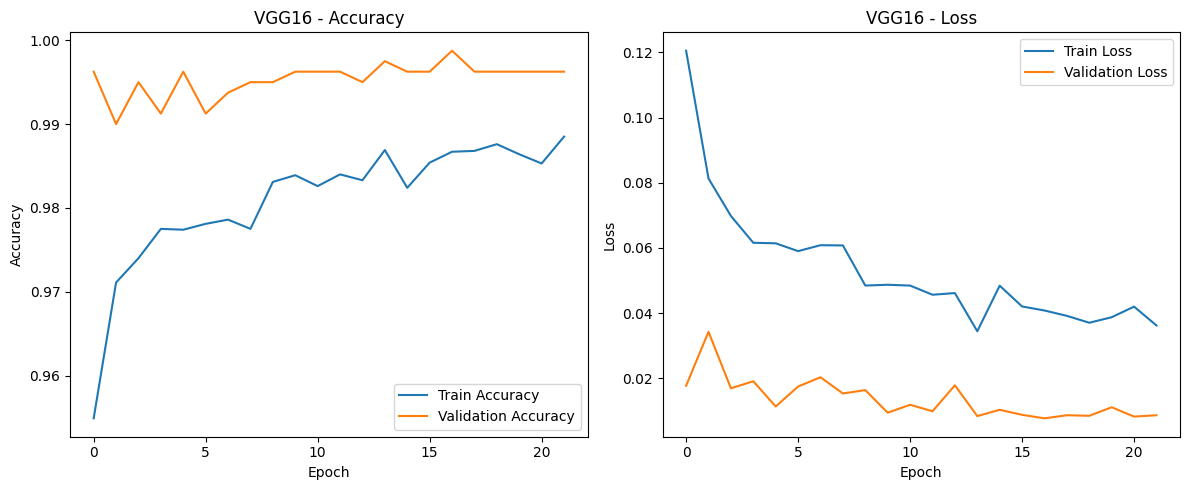

In [ ]:
# Prédictions sur l’ensemble de test
predictions = vgg16_model.predict(X_test, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Rapport de classification
print("\nClassification Report for VGG16:")
print(classification_report(true_labels, predicted_labels, target_names=categories))# Courbes de précision et de perte
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Interprétation :**

- Précision, rappel, F1-score : Toutes les métriques atteignent 1.00 (100 %) pour les deux classes (WithMask et WithoutMask), indiquant une performance parfaite au niveau des métriques individuelles. Cela est légèrement supérieur aux Simple CNN et Deep CNN, qui affichent 0.99 pour ces métriques.
- Support : 483 images pour WithMask, 509 pour WithoutMask, confirmant une répartition légèrement déséquilibrée mais parfaitement gérée par le modèle.
- La précision globale (99.60 %, basée sur la matrice de confusion) est légèrement inférieure à 100 % en raison de 4 erreurs, mais le rapport arrondi reflète l’excellence du modèle.

### **6.7. Visualisation des courbes d’apprentissage**


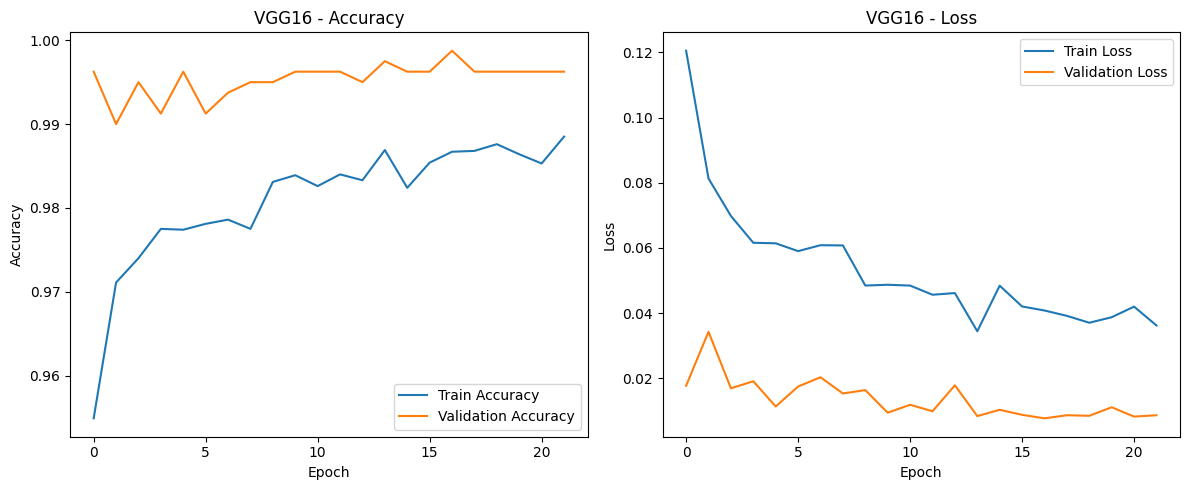

In [ ]:
# Courbes de précision et de perte
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **6.8. Matrice de confusion**

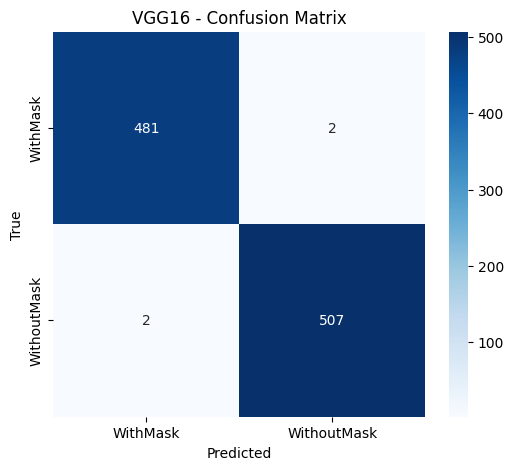

In [ ]:
# Matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('VGG16 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Interprétation :**

- Total des erreurs : 4 erreurs sur 992 images (2 WithMask prédits comme WithoutMask, 2 WithoutMask prédits comme WithMask), soit un taux d’erreur de 0.40 %, cohérent avec l’accuracy de 99.60 %.
- Comparé au Simple CNN (12 erreurs, 1.21 %) et au Deep CNN (6 erreurs, 0.60 %), VGG16 réduit encore le nombre d’erreurs, confirmant sa supériorité.
- Les erreurs sont équilibrées (2 par classe), indiquant aucun biais marqué. Les 4 erreurs pourraient être dues à des images particulièrement ambiguës (par exemple, masques transparents, flou, ou éclairage extrême).

### **6.9. Histogramme des prédictions**


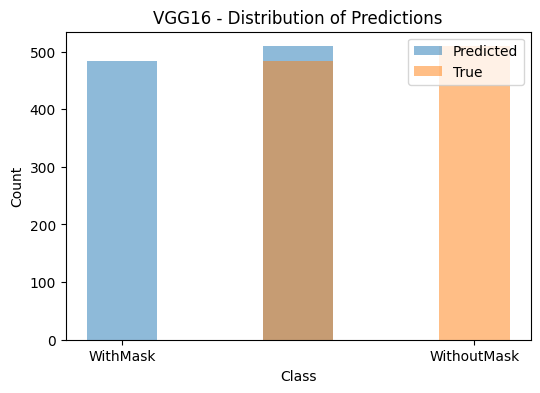

In [ ]:
# Histogramme des prédictions
plt.figure(figsize=(6, 4))
plt.hist(predicted_labels, bins=2, align='left', rwidth=0.4, label='Predicted', alpha=0.5)
plt.hist(true_labels, bins=2, align='right', rwidth=0.4, label='True', alpha=0.5)
plt.xticks([0, 1], categories)
plt.title('VGG16 - Distribution of Predictions')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()

### **6.10. Visualisation des prédictions**

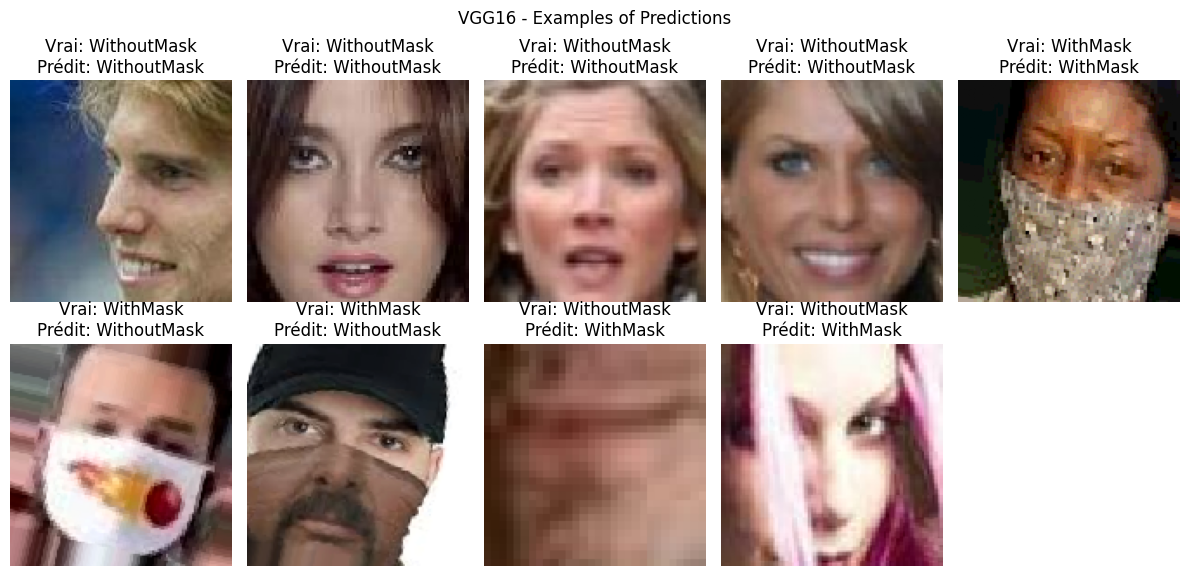

In [ ]:
# Sélectionner des prédictions correctes et incorrectes
correct_idx = np.where(predicted_labels == true_labels)[0]
incorrect_idx = np.where(predicted_labels != true_labels)[0]

# Afficher 5 prédictions correctes
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random.sample(list(correct_idx), min(5, len(correct_idx)))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {categories[true_labels[idx]]}\nPrédit: {categories[predicted_labels[idx]]}")
    plt.axis('off')

# Afficher 5 prédictions incorrectes
for i, idx in enumerate(random.sample(list(incorrect_idx), min(5, len(incorrect_idx)))):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {categories[true_labels[idx]]}\nPrédit: {categories[predicted_labels[idx]]}")
    plt.axis('off')

plt.suptitle('VGG16 - Examples of Predictions')
plt.tight_layout()
plt.show()

### **6.11. Analyse des résultats du VGG16**
#### *Progression de l’entraînement:*

- **Précision** : La précision de validation atteint 99.87 % à l’époque à l’ époque 97, mais termine à 99.62 % à l’époque à l’ époque 22 (arrêté précocement). La précision d’entraînement progresse de 93.60 % (époque (époque 1) à 99.03 % (époque (époque 22), indiquant une convergence rapide et robuste.
- **Perte** : La perte de validation diminue de 0.0177 (époque (époque 1) à un minimum de 0.0077 (époque (époque 97), avec une perte finale de 0.0087 (époque 22). La perte d’entraînement d’ entraînement passe de 0.1736 à 0.0306.
- **Taux d’apprentissage** : Réduit à 0.0005 à l’époque l’ époque 9, à 0.00025 à l’époque l’ époque 14, et à à 0.000125 à l’époque l’ époque 21, contribuant à une convergence fine-tuning.
- **Arrêt précoce** : L’entraînement L’ entraînement s’arrête à l’époque l’ époque 22, car la perte de validation n’a pas diminué pendant 5 moins époques consécutives (patience=5). Les meilleurs poids (époque (époque 17) ont été restaurés. restaurés.
#### *Analyse des courbes:*

- **Précision** : Les courbes montrent une convergence rapide, avec la validation atteignant 99.62 % dès l’époque l’ époque 1. Des fluctuations mineures (par exemple, 99.00 % à l’époque l’ époque 2) sont rapidement corrigées. La précision de test (99.60 %) est très proche de la validation maximale (99.87 %), confirmant une généralisation robuste.
- **Perte** : La perte de validation diminue régulièrement, atteignant un minimum de 0.0077 à l’époque l’ époque 17. Des augmentations temporaires (par exemple, 0.0343 à l’époque l’ époque 2) sont corrigées par l’ajustement l’ ajustement du taux d’apprentissage. d’ apprentissage. La perte de test (0.0136) est légèrement supérieure, mais reste extrêmement faible.
- L’écart L’ écart entre entraînement (99.03 %) et validation/test (99.87 %/99.60 %) indique un surapprentissage très léger, bien contrôlé par BatchNormalization et Dropout (0.5).
#### *Performance sur l’ensemble de test:*

- **Précision** : 99.60 %, légèrement inférieure à la validation maximale (99.87 % à l’époque l’ époque 17), mais supérieure au Deep CNN (99.40 %) et au Simple CNN (98.79 %).
- **Perte** : 0.0136, supérieure à la validation minimale (0.0077), mais inférieure au Deep CNN (0.0211) et au Simple CNN (0.0342).
Rapport de classification : Précision, rappel, et F1-score de 1.00 pour les deux classes, reflétant une performance quasi-parfaite.
- **Matrice de confusion** : 4 erreurs (2 par classe), le meilleur résultat parmi les trois modèles.
#### *Forces du modèle:*

- **Robustesse** : Les couches pré-entraînées pré-entraînées de VGG16 capturent des caractéristiques complexes, surpassant les modèles personnalisés (99.60 % vs 99.40 % Deep CNN, 98.79 % Simple CNN).
- **Haute précision** : Meilleure performance globale (99.60 %), avec seulement 4 erreurs.
- **Stabilité** : Meilleure performance globale (99.60 %), avec seulement 4 erreurs.
- **Équilibre** : Erreurs équilibrées (2 par classe), sans biais notable.
#### *Limites:*

- **Complexité** : Environ 15M paramètres, entraînement plus lent (~35s/époque, ~18 min pour 22 époques) que Simple CNN (~11 min pour 18 époques) et Deep CNN (~17 min pour 28 époques).
- **Ressources** : Nécessite un GPU pour un entraînement efficace, limitant son déploiement sur des appareils à faible puissance.
- **Erreurs résiduelles** : Les 4 erreurs suggèrent une sensibilité à des cas extrêmement ambigus (par exemple, masques transparents ou éclairage extrême).
- **Surapprentissage léger** : Écart entre entraînement (99.03 %) et test (99.60 %), bien que minime.
#### *Recommandations:*

- **Fine-tuning** : Dégeler les dernières couches de VGG16 avec un taux d’apprentissage d’ apprentissage faible (1e-5) pour améliorer la précision sur les cas limites.
- **Analyse des erreurs** : Examiner les 4 images mal classées (section 4.3.9) pour identifier les causes (par exemple, éclairage, position du masque).
- **Modèle plus léger** : Tester EfficientNetB0 pour un compromis entre précision et vitesse, surtout pour un déploiement sur des appareils à faible puissance.
- **Augmentation spécifique** : Ajouter brightness_range=[0.8, brightness_range=[0.8, 1.2]` pour mieux gérer les variations d’éclairage. d’ éclairage

# **7. Comparaison**

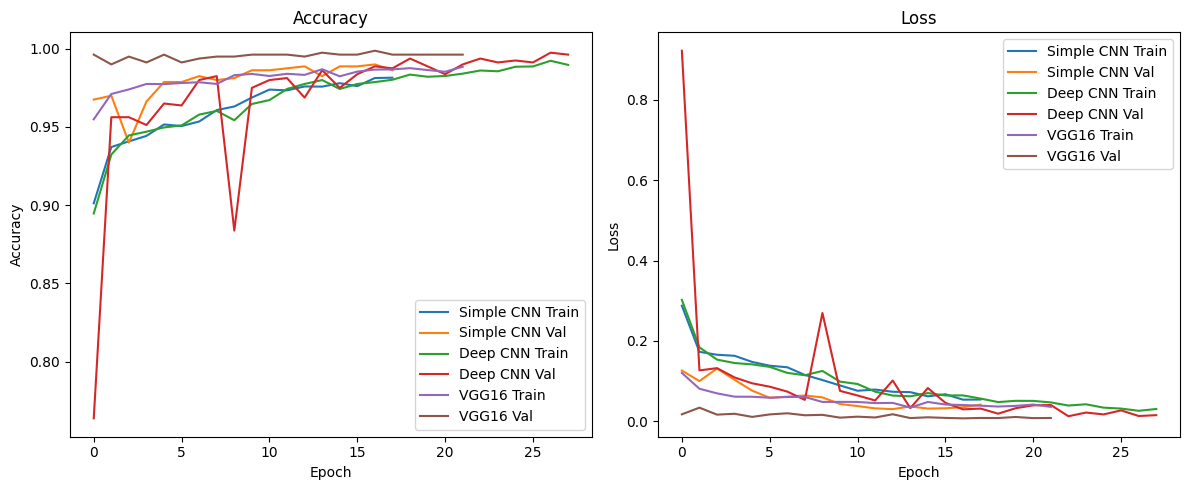

In [ ]:
models = {
    'Simple CNN': simple_cnn,
    'Deep CNN': deep_cnn,
    'VGG16': vgg16_model
}
histories = {
    'Simple CNN': history_simple,
    'Deep CNN': history_deep,
    'VGG16': history_vgg16
}

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

### *Synthèse*

Ce projet de deep learning, réalisé dans le cadre d'un travail de groupe, vise à détecter automatiquement le port de masques faciaux à l'aide de réseaux de neurones convolutifs (CNN). Dans un contexte où les mesures sanitaires restent essentielles, ce système de vision par ordinateur répond à un besoin d'automatisation pour identifier les catégories WithMask et WithoutMask dans des environnements publics tels que les transports ou les établissements de santé.

Le projet s'appuie sur le "Face Mask 12K Images Dataset" disponible sur Kaggle, un ensemble de *~*12 000 images équilibrées (*~*10 000 pour l'entraînement, *~*1 000 pour la validation, *~*1 000 pour le test). Le notebook documente un pipeline complet, incluant la recherche et l'importation des données, leur préparation (redimensionnement à 128x128 pixels, normalisation, encodage one-hot), et l'augmentation via ImageDataGenerator (rotation, décalage, zoom, retournement horizontal) pour améliorer la robustesse face aux variations réalistes.

Trois modèles CNN ont été développés et entraînés :





- *Simple CNN* : Entraîné sur 18 époques, ce modèle léger a atteint une précision de validation maximale de 99.00 % (époque 17) et une précision de test de 98.79 % (perte de 0.0342). Les courbes de précision et de perte montrent une convergence stable, avec un arrêt précoce efficace.



- *Deep CNN* : Entraîné sur 28 époques, ce modèle plus complexe a obtenu une précision de validation maximale de 99.37 % (époque 23) et une précision de test de 99.40 % (perte de 0.0211). Les visualisations révèlent une convergence rapide malgré une instabilité initiale.



- *VGG16* : Utilisant le transfert d'apprentissage sur 22 époques, ce modèle pré-entraîné a atteint une précision de validation maximale de 99.87 % (époque 17) et une précision de test de 99.60 % (perte de 0.0136). Les courbes indiquent une convergence très stable.

Les visualisations des précisions et pertes par époque confirment la capacité des modèles à apprendre efficacement, avec des courbes reflétant une optimisation progressive. Les performances de test, soutenues par des matrices de confusion (12, 6, et 4 erreurs respectivement), témoignent de la robustesse du pipeline. Cependant, des erreurs résiduelles suggèrent une sensibilité aux cas ambigus, comme les variations d'éclairage ou les masques mal positionnés.

Ce projet illustre l'efficacité des CNN pour la détection de masques faciaux, avec des résultats proches de la perfection. Pour aller plus loin, il est recommandé d'analyser les erreurs pour enrichir l'augmentation des données (par exemple, brightness_range=[0.8, 1.2]), d'explorer des architectures plus légères comme EfficientNet pour des déploiements pratiques, et d'optimiser les hyperparamètres (par exemple, augmenter la patience de l'arrêt précoce). Le notebook constitue une base solide pour de futures applications en vision par ordinateur, démontrant la puissance d'un pipeline bien structuré.